<a href="https://colab.research.google.com/github/UlyShel/basics_of_deep_learning/blob/main/HW_TS_Shelegova_GROUP5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

### ИАД. 2024-2025

### Прогнозирование временных рядов

Мы постарались составить домашнее задание так, чтобы оно помогло закрепить все то, что мы прошли за 2 недели на лекциях и семинарах. Вы вольны использовать любые библиотеки, которые вам нравятся. Главное — это осознанность в выборе методов и интерпретации выводов.

В рамках домашнего задания будем работать с датасетом `NN5`, который можно скачать [здесь](https://zenodo.org/records/4656117). Временные ряды в этом датасете представляют собой данные по ежедневным снятиям наличных в банкоматах в Великобритании.

### Задание 1. Первичный анализ данных (1 балл)

In [ ]:
! pip install statsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 4.3 MB/s eta 0:00:00


In [ ]:
import logging

logger = logging.getLogger(__name__)
import sys

c_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(c_handler)
logging.basicConfig(level=logging.INFO, force=True)

import random
import warnings
from datetime import datetime
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from statsforecast import StatsForecast, models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

warnings.filterwarnings("ignore")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
def mase(
    forecast: np.ndarray,
    insample: np.ndarray,
    outsample: np.ndarray,
    frequency: int,
) -> np.ndarray:
    """MASE loss as defined in "Scaled Errors" https://robjhyndman.com/papers/mase.pdf

    Args:
        forecast: Forecast values. Shape: batch, time_o
        insample: Insample values. Shape: batch, time_i
        outsample: Target values. Shape: batch, time_o
        frequency: Frequency value
    Returns:
        Same shape array with error calculated for each time step
    """
    return np.mean(np.abs(forecast - outsample)) / np.mean(
        np.abs(insample[:-frequency] - insample[frequency:])
    )

Нам пригодятся уже знакомые функции с семинаров по чтению рядов в формате tsf. Напомню, что иногда временные ряды могут быть представлены в tsf формате. Это такая структура данных, которая позволяет хранить метаинформацию о временных рядах, а также пары "первая дата — все значения временного ряда".

Функции позволяют считать данные в tsf формате и перевести их в формат, которым мы можем пользоваться.

In [ ]:
def convert_tsf_to_dataframe(
    full_file_path_and_name: str,
    replace_missing_vals_with: Any = "NaN",
    value_column_name: str = "series_value",
) -> tuple[pd.DataFrame, str, int, str, str]:
    """
    Конвертирует файл формата TSF в pandas DataFrame.

    Args:
        full_file_path_and_name: Путь к файлу формата TSF.
        replace_missing_vals_with: Значение для замены пропусков.
        value_column_name: Имя столбца для значений временных рядов.

    Returns:
        DataFrame с данными временных рядов.
        Частота данных.
        Прогнозируемый горизонт.
        Содержат ли данные пропуски.
        Равны ли длины временных рядов.

    """
    col_names = []
    col_types = []
    all_data = {}
    all_series = []
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    data_started = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            line = line.strip()
            if not line:
                continue
            if line.startswith("@"):
                if line.startswith("@data"):
                    data_started = True
                    # Инициализируем словарь для данных атрибутов
                    for col in col_names:
                        all_data[col] = []
                else:
                    parts = line.split(" ")
                    if line.startswith("@attribute"):
                        col_names.append(parts[1])
                        col_types.append(parts[2])
                    elif line.startswith("@frequency"):
                        frequency = parts[1]
                    elif line.startswith("@horizon"):
                        forecast_horizon = int(parts[1])
                    elif line.startswith("@missing"):
                        contain_missing_values = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
                    elif line.startswith("@equallength"):
                        contain_equal_length = parts[1].lower() in (
                            "y",
                            "yes",
                            "t",
                            "true",
                            "on",
                            "1",
                        )
            elif not line.startswith("#") and data_started:
                parts = line.split(":")
                # Последняя часть содержит значения ряда
                series_vals = parts[-1].split(",")
                numeric_series = [
                    replace_missing_vals_with if val == "?" else float(val) for val in series_vals
                ]
                all_series.append(pd.Series(numeric_series).array)
                # Преобразуем и сохраняем значения атрибутов
                for i in range(len(col_names)):
                    if col_types[i] == "numeric":
                        all_data[col_names[i]].append(int(parts[i]))
                    elif col_types[i] == "string":
                        all_data[col_names[i]].append(parts[i])
                    elif col_types[i] == "date":
                        all_data[col_names[i]].append(
                            datetime.strptime(parts[i], "%Y-%m-%d %H-%M-%S")
                        )

    all_data[value_column_name] = all_series
    loaded_data = pd.DataFrame(all_data)
    return loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length


def date_to_daterange(x: pd.Series, freq: str) -> pd.Series:
    """
    Преобразует временные метки в диапазон дат.

    Args:
        x: Временные метки.
        freq: Частота.

    Returns:
        pd.Series с диапазоном дат.

    """
    return pd.Series(pd.date_range(start=x.iloc[0], periods=len(x), freq=freq))


def convert_tsf_to_multivariate_or_standard_format(
    tsf_data_path: str,
    target_column: str = "series_value",
    date_from_column: str = "start_timestamp",
    id_column: str = "series_name",
    # one from ["multivariate", "standard"]
    format: str = "multivariate",
) -> pd.DataFrame:
    """
    Преобразует данные формата TSF в формат pandas DataFrame:
        если format == "standard" -> датафрейм с колонками "id", "date" и "value"
        если format == "multivariate" -> pivot таблица c date в качестве индекса,
            id в качестве колонок и значениями из value_column_name

    Args:
        tsf_data_path: Путь к файлу формата TSF.
        target_column: Имя столбца с целевой переменной.
        date_from_column: Имя столбца с переменной дат.
        id_column: Имя столбца с идентификаторами временных рядов.
        format: Формат данных ("multivariate" или "standard").

    Returns:
        pd.DataFrame с данными в формате "id", "date" и "value".

    """
    FREQ_MAP = {
        "monthly": "MS",
        "10_minutes": "10min",
        "half_hourly": "30min",
        "minutely": "1min",
        "daily": "D",
        "weekly": "7D",
        "yearly": "YS",
        "quarterly": "QS",
        "hourly": "H",
    }

    tsf_df, freq = convert_tsf_to_dataframe(tsf_data_path)[:2]

    # Преобразуем списки в {target_column} в "длинный столбец" со значениями
    tsf_df = tsf_df.explode(target_column)
    # Заменим повторяющиеся значения даты в {date_column} на date_range
    tsf_df["date"] = (
        tsf_df.groupby(id_column, sort=False)[date_from_column]
        .apply(lambda x: date_to_daterange(x, FREQ_MAP[freq]))
        .values
    )
    tsf_df = tsf_df.drop(columns=date_from_column)
    # Переименуем колонки
    tsf_df = tsf_df.rename(columns={id_column: "id", target_column: "value"}).reset_index(
        drop=True
    )
    # Приведем {id_column} к численным значениям
    ids2num = dict(zip(tsf_df["id"].unique(), np.arange(tsf_df["id"].nunique())))
    tsf_df["id"] = tsf_df["id"].map(ids2num)

    if format == "standard":
        return tsf_df
    return pd.pivot_table(tsf_df, values="value", index="date", columns="id")

#### Задание 1.1: Загрузка данных (0 баллов)

Давайте скачаем датасет __NN5__ и загрузим его, воспользовавшись функцией `convert_tsf_to_multivariate_or_standard_format`.

In [ ]:
!wget "https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1" -O nn5_daily_dataset_without_missing_values.zip
!unzip -o nn5_daily_dataset_without_missing_values.zip
!rm nn5_daily_dataset_without_missing_values.zip

--2025-05-23 16:53:51--  https://zenodo.org/records/4656117/files/nn5_daily_dataset_without_missing_values.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289779 (283K) [application/octet-stream]
Saving to: ‘nn5_daily_dataset_without_missing_values.zip’

nn5_daily_dataset_w 100%[===================>] 282.99K   667KB/s    in 0.4s    

2025-05-23 16:53:52 (667 KB/s) - ‘nn5_daily_dataset_without_missing_values.zip’ saved [289779/289779]

Archive:  nn5_daily_dataset_without_missing_values.zip
  inflating: nn5_daily_dataset_without_missing_values.tsf  


In [ ]:
df = convert_tsf_to_multivariate_or_standard_format(
    "nn5_daily_dataset_without_missing_values.tsf", format="standard"
)
df.head()

,id,value,date
0,0,13.407029,1996-03-18
1,0,14.725057,1996-03-19
2,0,20.564059,1996-03-20
3,0,34.70805,1996-03-21
4,0,26.629819,1996-03-22


#### Задание 1.2: Типы данных (0.3 балла)

Выведите типы данных в датасете. Проверьте, что они корректные: даты должны быть в формате datetime, id — object, а значения временных рядов — float. Если это не так, то исправьте их.

In [ ]:
df.dtypes

,0
id,int64
value,object
date,datetime64[ns]


In [ ]:
df = df.astype({"id": "object", "value": "float"})
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes

,0
id,object
value,float64
date,datetime64[ns]


#### Задание 1.3: Пропуски (0.05 балла)

Проверьте, есть ли в данных пропуски. Если они есть, то заполните их предыдущими значениями. Если пропусков нет, то просто выведите сообщение об этом.

In [ ]:
print(f'Есть пропущенные данные: {df.isna().values.any()}')

Есть пропущенные данные: False


#### Задание 1.4: Визуальный анализ временных рядов (0.4 балла)

Постройте линейные графики временных рядов. По оси X отложите время, по оси Y — значения временного ряда.

Используйте Plotly, чтобы можно было отложить сразу все временные ряды на одном графике.

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)


seed_everything()

In [ ]:
fig = go.Figure()
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 5, replace=False)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(title="Daily cash withdrawals from ATMs in UK", xaxis_title="Date", yaxis_title="Value")
fig.show()

In [ ]:
fig = go.Figure()
seed_everything()
random_ids = np.random.choice(df["id"].unique(), 1, replace=False) # вывела специально и для одного ряда, потому что из-за высокой частотности сложно охарактеризовать ряды (все смешиваются)

for i in random_ids:
    fig.add_trace(
        go.Scatter(x=df[df["id"] == i]["date"], y=df[df["id"] == i]["value"], name=str(i))
    )
fig.update_layout(title="Daily cash withdrawals from ATMs in UK", xaxis_title="Date", yaxis_title="Value")
fig.show()

In [ ]:
# KPSS test
# H0: временной ряд стационарен
# H1: временной ряд не стационарен
statistic, p_value, lags, critical_values = kpss(df["value"])
print(f"KPSS p-value: {p_value}")

# ADF test
# H0: unit root (не стационарен)
# H1: no unit root (стационарен)
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(df["value"])
print(f"ADF p-value: {p_value}")

# неоднозначные результаты, по КПСС тесту ряд нестационарен, а по ADF - стационарен (наверное, потому что не виден явный тренд)

KPSS p-value: 0.01
ADF p-value: 3.69838077591535e-21


__Ответьте на следующие вопросы:__

- Какова частотность (frequency) данных?

Ежедневная.

- Выровнены ли временные ряды?

Да, для всех наблюдений id имеются наблюдения на одни и те же даты.

- Стационарны ли временные ряды? Если нет, то какие признаки нестационарности вы можете выделить?

Есть чувство, что нестационарные: 1) тренда нет заметного; 2) тем не менее видны периодические колебания (каждые 7/14 дней, вроде как). Но, возможно, это циклы, потому что амлитуда не фиксирована и не увеличивается со временем, но стационарность не характеризуется циклами. Судя по КПСС тесту ряд нестационарен. Короче, сложно сказать точно

- На какие группы можно разбить временные ряды по наличию общих признаков? Есть ли что-то, чем похожи все временные ряды?

На группы сложно разбить, но я четко вижу, что они, возможно, повторяют похожий паттерн пиков примерно каждые 7-14 дней.

- Есть ли в рядах выбросы? Как вы можете это определить?

Да, видны сильные всплески, которые не вписываются в тренд (27 марта 1997). Определить можно визуально, посмотрев на особо сильные амплитудные колебания.

#### Задание 1.5: Выделение тестовой выборки (0.25 балла)

Выделите 10% данных для теста, а остальные 90% оставьте для обучения. Делайте это очень аккуратно, чтобы не нарушить временную и многомерную структуру данных!

Вспомните и напишите, в чем особенность выделения тестовой выборки в задаче прогнозирования временных рядов и в задаче прогнозирования __многомерных__ временных рядов.

**ОТВЕТ**: Все временные ряды должны быть разбиты одинаково (по 1 и тем же датам). То есть, если у одного тест начинается с 15 марта, то и другого аналогично.

Обратите внимание, что временные ряды выровнены, а значит, в отличие от семинара, пробегаться в цикле по каждому id не нужно. Подумайте, как можно сделать это более эффективно.

In [ ]:
df_sorted = df.sort_values("date")

unique_dates = df_sorted["date"].unique()
n_dates = len(unique_dates)
split_date = unique_dates[int(n_dates * 0.9)] # дата, по которой будем делить датасет (потому что если делить датасет буквально через iloc, есть шанс, что временные ряды одной даты будут находиться сразу и в трейне, и тесте)

train_df = df_sorted[df_sorted["date"] < split_date]
test_df = df_sorted[df_sorted["date"] >= split_date]

### Задание 2. Полный анализ одного временного ряда (4 баллов)

#### Задание 2.1: Визуальный анализ (0.5 балла)

Выделите из данных временной ряд с номером 92. Постройте его линейный график.

In [ ]:
train_92 = train_df[train_df['id'] == 92]
test_92 = test_df[test_df['id'] == 92]

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_92["date"], y=train_92["value"], name="Train", line=dict(color="blue"))
)
fig.add_trace(
    go.Scatter(x=test_92["date"], y=test_92["value"], name="Test", line=dict(color="red"))
)
fig.update_layout(
    title="Train/Test Split", xaxis_title="Date", yaxis_title="Value"
)
fig.show()

Постройте графики автокорреляций (ACF) и частных автокорреляций (PACF) до 40-го лага для тренировочной выборки.

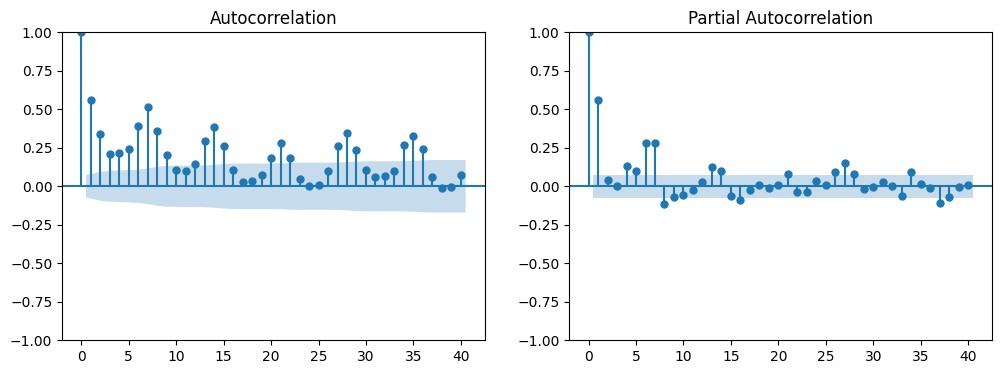

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(train_92["value"], lags=40, ax=ax[0])
plot_pacf(train_92["value"], lags=40, ax=ax[1])
plt.show()

In [ ]:
# KPSS test
statistic, p_value, lags, critical_values = kpss(train_92["value"])
print(f"KPSS p-value: {p_value}")

# ADF test
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(train_92["value"])
print(f"ADF p-value: {p_value}")

# опять-таки неоднозначные результаты, по КПСС тесту ряд нестационарен, а по ADF - стационарен
#  это сигнал слабой/частичной нестационарности, поэтому все-таки надо сделать хоть одно дифферницирование

KPSS p-value: 0.01
ADF p-value: 0.001091824760471662


__Ответьте на следующие вопросы:__
- Стационарен ли временной ряд?

Нет, во-первых на ACF значения убывают медленно, что уже является признаком нестационарности (https://otexts.com/fpp2/stationarity.html). Во-вторых, прослеживается сезонность с пиками через каждые 7-8 точек. Тесты дают противоречивеы результаты, но как раз судя по КПСС временной ряд все-таки не стационарен.

- Присутствует ли в нём тренд? Сезонность? Цикличность?

Тренд присутствует, потому что ACF показывает медленно убывающие положительные автокорреляции (So the ACF of a trended time series tends to have positive values that slowly decrease as the lags increase. - https://otexts.com/fpp3/acf.html). Так же у ACF есть явнопотворяющиеся пики каждые 7 шагов, что говорит о присутствии сезонности (https://otexts.com/fpp3/acf.html). Тем не меннее, учитывая то, что эти пики могут смещаться (например, первый пик через 8 шагов, а не 7), что может говорить о нерегулярности -> цикличности, а не сезонности. Но это мы скажем уже после дифференцирования.

- Если ряд сезонный, то какой период выглядит наиболее вероятным?

7-8 лагов выгялдит наиболее вероятным периодом, то есть сезонность скорее всего сезонная.

#### Задание 2.2: Построение модели SARIMA (2 балла)

Пользуясь правилами отсюда: https://people.duke.edu/~rnau/arimrule.htm, попробуйте подобрать параметры SARIMA модели, как мы делали это на семинаре.

Не забудьте о возможности использовать предобработку данных, например, логарифмирование и удаление выбросов (самое простое — это воспользоваться IQR: https://medium.com/@divyansh9144/iqr-interquartile-range-for-anomaly-detection-f9c568d1195f).

Если вы используете предобработку, то обязательно укажите, какую именно и почему.

In [ ]:
log_train_data = np.log1p(train_92['value'])

# удалила выбросы благодаря этому тутору: https://gist.github.com/divyansh8866/ed6e7fec73f43ee9d6fd1d9b53affcbc
# я удалила выбросы и сделала логарифмирование данных, чтобы сделать данные ближе к стационарным, чтобы обучение было более гладким

Q1 = log_train_data.quantile(0.25)
Q3 = log_train_data.quantile(0.75)
IQR = Q3 - Q1

threshold_lower = Q1 - 1.5 * IQR
threshold_upper = Q3 + 1.5 * IQR

log_train_data_clean = log_train_data[~((log_train_data < threshold_lower) | (log_train_data > threshold_upper))]

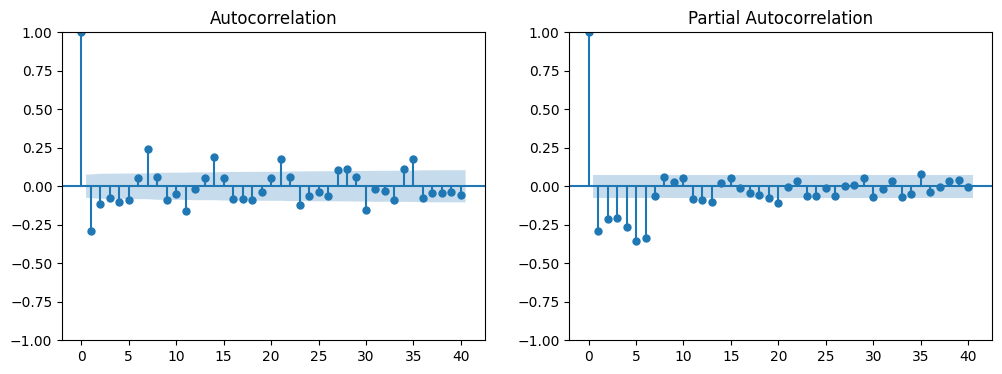

In [ ]:
# ACF и PACF после обычного дифференцирования
diff_seas_series = log_train_data_clean.diff().dropna()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(diff_seas_series, lags=40, ax=ax[0])
plot_pacf(diff_seas_series, lags=40, ax=ax[1])
plt.show()

# по ACF: p = 4; по PACF:  q = 1 -  резко падает после лага 1 + d = 2 (обычное дифференцирование)

In [ ]:
# KPSS test
statistic, p_value, lags, critical_values = kpss(diff_seas_series)
print(f"KPSS p-value: {p_value}")

# ADF test
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(diff_seas_series)
print(f"ADF p-value: {p_value}")

# наконец временной ряд стационарен по всем тестам. больше диффернцирвоать не будет, а то будет overdifferencing

KPSS p-value: 0.1
ADF p-value: 1.1556014433546255e-14


Буду анализирвоать по этому видео: https://www.youtube.com/watch?v=wfDstwTdoxU&list=LL&index=2 не обессудьте

По этому графику видно, что ACF и PACF затухают, а не обрываются -> значит модель ARMA(p,q).

Non-seasonal(p,d,q):
- p = 1-2 (затухание после 2-3 лагов)
- d = 1 (обычное дифференцирование)
- q = 1-2 (затухание после 2-3 лагов)

Судя по всплескам на 7,17, 21, есть сезонность.

Seasonal (P,D,Q)m:
- P = 1
- D = 1 (присутствует сезонность с периодом 7 → сезонная дифференцирвание D = 1)
- Q = 1
- m = 7

Получется, SARIMA(1, 1, 1)(0,1,1,7) или SARIMA(2, 1, 2)(0,1,1,7)

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                  683
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  25.077
Date:                           Fri, 23 May 2025   AIC                            -40.155
Time:                                   17:54:38   BIC                            -17.648
Sample:                                        0   HQIC                           -31.435
                                           - 683                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2078      0.032      6.526      0.000       0.145       0.270
ma.L1         -0.9278      0.016    -59.572

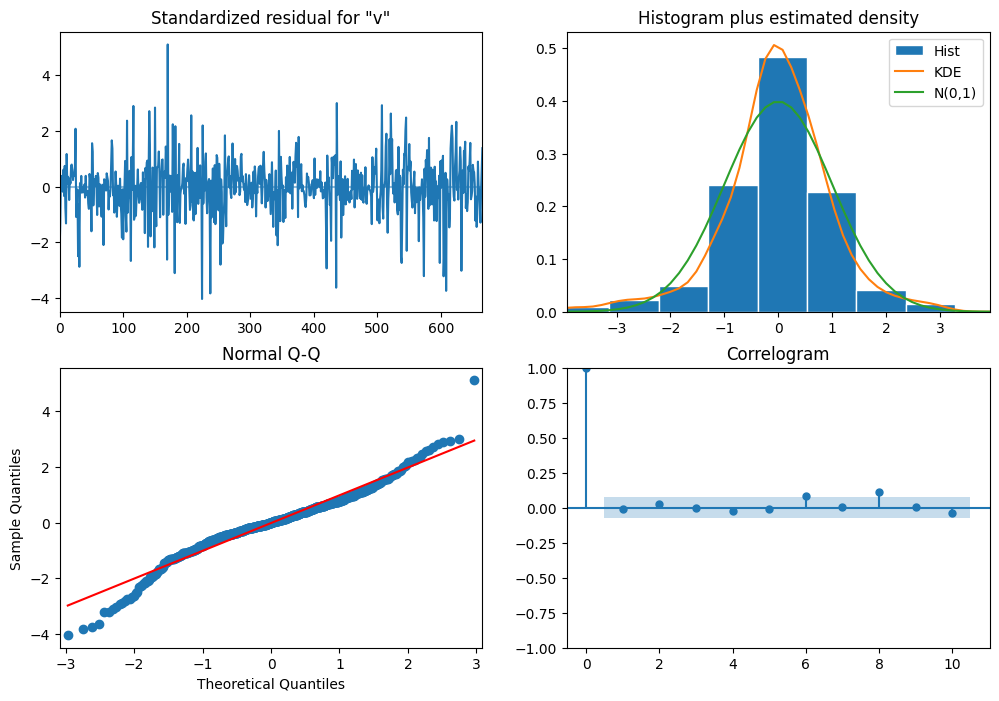

In [ ]:
model = SARIMAX(
    log_train_data_clean,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                  683
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                  30.298
Date:                             Fri, 23 May 2025   AIC                            -46.597
Time:                                     17:54:00   BIC                            -15.098
Sample:                                          0   HQIC                           -34.392
                                             - 683                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9640      0.142      6.775      0.000       0.685       1.243
ar.L2         -0.1084      

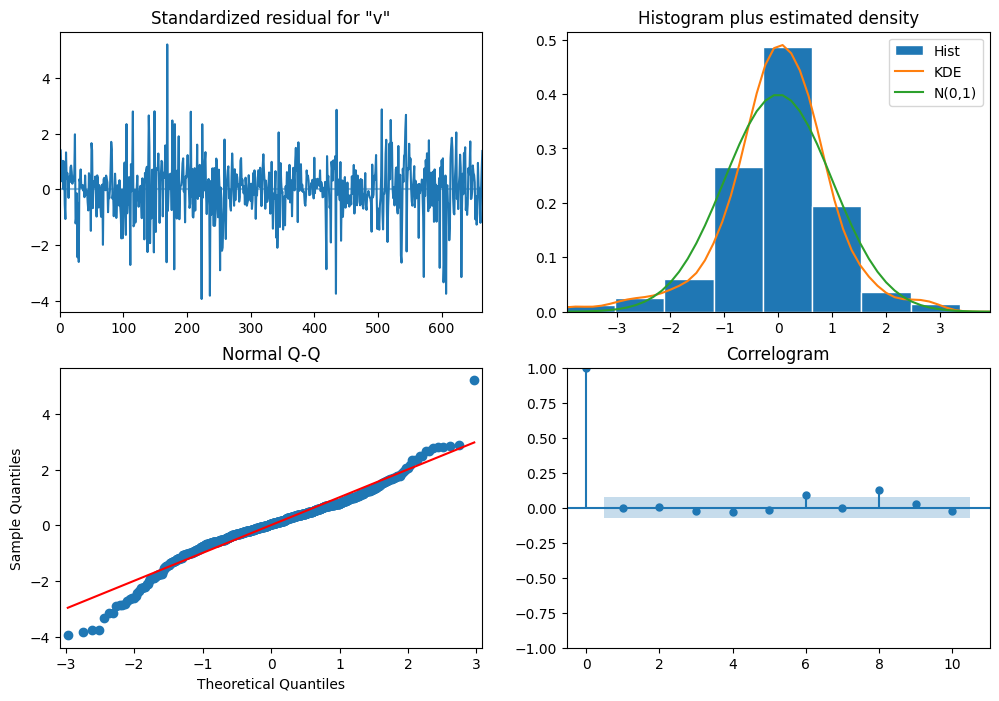

In [ ]:
model2 = SARIMAX(
    log_train_data_clean,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit2 = model2.fit(disp=False)
print(model_fit2.summary())

model_fit2.plot_diagnostics(figsize=(12, 8))
plt.show()

# BIC тут меньше, возьмем эту модель

#### Задание 2.3: Анализ остатков (0.5 баллов)

Постройте графики ACF и PACF остатков модели SARIMA. Проверьте, что в остатках нет значимых автокорреляций. Если они есть, то попробуйте объяснить, почему это происходит.

Проведите тест на стационарность остатков модели. Проведите тест на автокорреляцию остатков модели. Проинтерпретируйте результаты тестов. Если тесты показывают, что остатки нестационарны или в них есть автокорреляция, то попробуйте объяснить, почему это происходит.

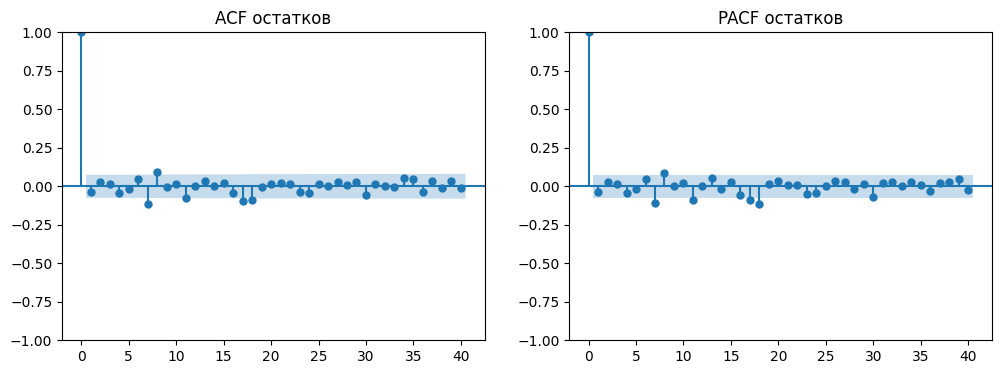

In [ ]:
residuals = model_fit.resid

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=40, ax=ax[0], title="ACF остатков")
plot_pacf(residuals, lags=40, ax=ax[1], title="PACF остатков")
plt.show()

# в остатках модели нет выраженной автокорреляции, получается модель хорошо объясняет зависимость в данных

In [ ]:
# H0: остатки стационарны
statistic, p_value, lags, critical_values = kpss(residuals)
print(f"KPSS p-value: {p_value}") # остатки стационарны

# H0: остатки не стационарны
statistic, p_value, usedlag, _, critical_values, icbest = adfuller(residuals)
print(f"ADF p-value: {p_value}") # остатки стационарны

# H0: автокорреляция отсутствует
lb_test = acorr_ljungbox(residuals, lags=[10, 26], return_df=True)
print(lb_test) # автокорреляция остатков статистически незначима -> автокорреляция отсутствует

KPSS p-value: 0.1
ADF p-value: 2.9309070619975253e-12
      lb_stat  lb_pvalue
10  20.354369   0.026074
26  42.294198   0.022889


#### Задание 2.4: Получение прогнозов и выводы (1 балл)

С помощью полученной модели постройте прогноз на тестовую выборку.

Постройте график прогноза и фактических значений. Сделайте выводы о том, насколько хорошо модель предсказывает временной ряд.

Посчитайте метрику MASE, которую мы имплементировали в начале ноутбука. Объясните, что она показывает и почему ее потенциально полезнее использовать для сравнения моделей, чем MAE или MAPE. Выводы по самому значению метрики делать не нужно.

**Ответ**: (1) MASE устойчив к проблемам MAPE, особенно когда в данных есть нули. MAPE в таких случаях может просто выдавать бесконечность, а MASE нет.
(2) MASE не зависит от масштаба данных, потому что основан на относительной ошибке. Это удобно при сравнении моделей на разных временных рядах. MAE вообще не учитывает масштаб и сезонность (https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968)

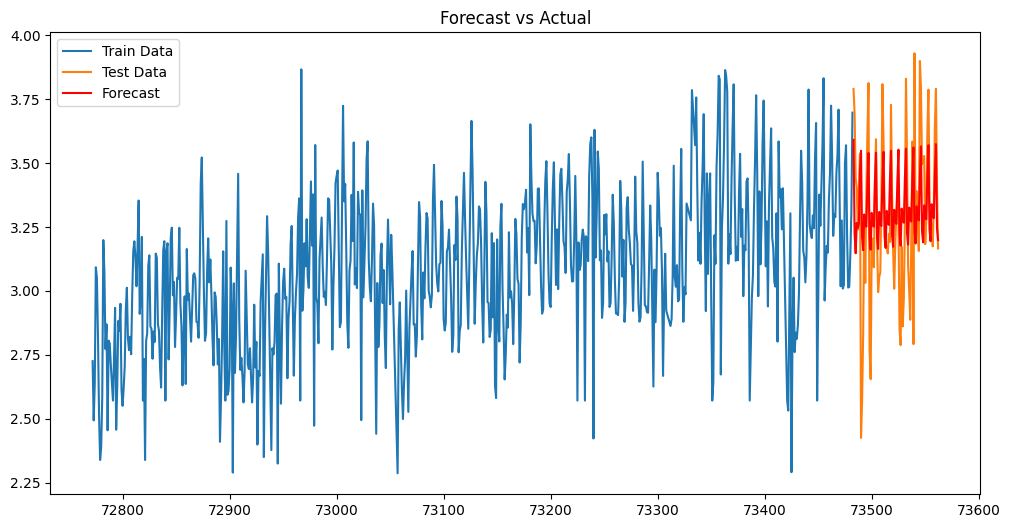

In [ ]:
log_test_data = np.log1p(test_92["value"].astype("float"))
HORIZON = len(log_test_data)
forecast = model_fit2.get_forecast(steps=HORIZON)
forecast_values = forecast.predicted_mean

plt.figure(figsize=(12,6))

plt.plot(log_train_data_clean.index, log_train_data_clean, label='Train Data')
plt.plot(log_test_data.index, log_test_data, label='Test Data')
plt.plot(log_test_data.index, forecast_values, label='Forecast', color='red')

plt.legend()
plt.title('Forecast vs Actual')
plt.show()

In [ ]:
mase_value = mase(
    forecast= forecast_values.values,
    insample=log_train_data.values,
    outsample=log_test_data.values,
    frequency=7
)

print(f'MASE: {mase_value:.4f}')

# вывод: эта модель лучше наивной, потому что:
# https://www.ibm.com/docs/en/cognos-analytics/11.1.x?topic=forecasting-statistical-details
# If the MASE is greater than 1, then the model is worse than the naive model. The lower the MASE, the better the model is compared to the naive model.

MASE: 0.7685


### Задание 3. Построение бейзлайнов на всех рядах и автоматический подбор параметров (2 балла)

#### Задание 3.1: Запуск бейзлайнов (1 балл)
Давайте будем использовать statsforecast для бейзлайнов, так же как мы делали это на семинаре: https://nixtlaverse.nixtla.io/statsforecast/index.html

Постройте прогнозы на всех рядах с помощью следующих бейзлайнов:
- Naive
- Seasonal Naive
- AutoARIMA
- еще 2 на ваш выбор (например, ETS, Theta, TBATS или другие, которые вам нравятся). Кратко опишите суть выбранных моделей.

In [ ]:
train_df = train_df.rename(columns={'id': 'unique_id', 'date': 'ds', 'value': 'y'}, inplace=True)
HORIZON = len(log_test_data)

models_lst = [
    models.Naive(),
    models.SeasonalNaive(season_length=7),
    models.AutoARIMA(),
    models.AutoETS(season_length=7), #сам выбирает тип тренда (аддитивный/мультипликативный), сезонности и ошибки по минимальному AIC/BIC. выбрала, потому что он хорошо работает при наличии тренда и сезонности (наш случай)
    models.AutoTheta() # простые линейные тренды + сглаживание. у меня на нее не особо много надежд, потому что она лучше рабоатет для монотонных рядов, но посмотрим
]

sf = StatsForecast(models=models_lst, freq="D", n_jobs=-1)

forecast_df = sf.forecast(df=train_df, h=HORIZON)

print(forecast_df.head())

   unique_id         ds      Naive  SeasonalNaive  AutoARIMA    AutoETS  \
0          0 1998-02-27  62.471655      42.219388  46.993280  42.371708   
1          0 1998-02-28  62.471655      30.938209  34.239125  29.602472   
2          0 1998-03-01  62.471655      25.864512  25.922931  28.477031   
3          0 1998-03-02  62.471655      21.230159  24.805757  25.256084   
4          0 1998-03-03  62.471655      29.733560  30.173344  33.060506   

   AutoTheta  
0  38.058419  
1  38.079039  
2  38.099658  
3  38.120278  
4  38.140898  


#### Задание 3.2: Анализ результатов (1 балл)

Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Выведите метрики MASE.

Что можно сказать о каждом из бейзлайнов? Какой из бейзлайнов лучше всего предсказывает временной ряд?

Смогли ли вы руками подобрать гиперпараметры для SARIMA модели лучше, чем автоматический подбор в библиотеке? Если да, то вы огромный молодец! Если нет, то не расстраивайтесь, так бывает.

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id = 92):
    """
    Функция для анализа предсказаний модели.
    Вычисляет MASE для ряда с id=92 и строит график предсказаний и истинных значений.

    Args:
        train_df: Обучающая выборка.
        test_targets: Целевые значения для тестовой выборки.
        current_pred: Предсказания модели.
        last_points: Количество последних точек в тренировочной выборке для отображения на графиках.
    """
    train_df = train_df.rename(columns={
        "unique_id": "id",
        "y": "value",
        "ds": "date",
    })

    fig = go.Figure()

    # Тренировочные данные
    train_series = train_df[train_df["id"] == row_id]
    train_series = train_series.iloc[-min(len(train_series), last_points):]
    train_values = train_series["value"].tolist()
    n_train = len(train_values)

    # Тестовая цель и предсказания
    test_targets_series = test_targets[test_targets["id"] == row_id]
    target_values = test_targets_series["value"].values  # np.ndarray

    preds_series = current_pred[current_pred["id"] == row_id]
    preds_values = preds_series["value"].values  # np.ndarray

    n_test = len(target_values)

    # MASE
    full_insample = train_df[train_df["id"] == row_id]["value"].values
    mase_score = mase(forecast=preds_values, insample=full_insample, outsample=target_values, frequency=7)
    print(f"MASE: {mase_score:.4f}")

    # Оси
    x_train = np.arange(-n_train, 0)
    x_test = np.arange(0, n_test)
    x_pred = np.arange(0, n_test)

    # Графики
    fig.add_trace(go.Scatter(
        x=x_train,
        y=train_values,
        mode="lines",
        name=f"id {row_id} train"
    ))

    fig.add_trace(go.Scatter(
        x=x_test,
        y=target_values,
        mode="lines",
        name=f"id {row_id} true"
    ))

    fig.add_trace(go.Scatter(
        x=x_pred,
        y=preds_values,
        mode="lines",
        name=f"id {row_id} pred",
        line=dict(dash="dash")
    ))

    fig.add_shape(dict(
        type="line",
        x0=0,
        y0=0,
        x1=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="red", width=2)
    ))

    fig.update_layout(
        title="Prediction vs True Values for id=92",
        xaxis_title="Time (relative)",
        yaxis_title="Values"
    )

    fig.show()

In [ ]:
current_pred = forecast_df.rename(columns={
    "unique_id": "id",
    "ds": "date",
})

current_pred_seas_naive = current_pred[["id", "date", "SeasonalNaive"]].rename(columns={"SeasonalNaive": "value"})
current_pred_naive = current_pred[["id", "date", "Naive"]].rename(columns={"Naive": "value"})
current_pred_arima = current_pred[["id", "date", "AutoARIMA"]].rename(columns={"AutoARIMA": "value"})
current_pred_ets = current_pred[["id", "date", "AutoETS"]].rename(columns={"AutoETS": "value"})
current_pred_theta = current_pred[["id", "date", "AutoTheta"]].rename(columns={"AutoTheta": "value"})

In [ ]:
analyze_predictions(train_df, test_92, current_pred_naive, last_points=50)

MASE: 2.6212


In [ ]:
analyze_predictions(train_df, test_92, current_pred_seas_naive, last_points=50)

MASE: 1.1528


In [ ]:
analyze_predictions(train_df, test_92, current_pred_arima, last_points=50)

MASE: 1.3990


In [ ]:
analyze_predictions(train_df, test_92, current_pred_ets, last_points=50)

MASE: 1.0433


In [ ]:
analyze_predictions(train_df, test_92, current_pred_theta, last_points=50)

MASE: 1.4101


Лучше всего предсказывает ETS (1.04), на втором месте - сезонная наивность (1.16), что неудивительно! Наш датасет имеет ярковыраженную сезонность, а эти модели как раз и заточены на поиск сезонности. Как я и прогнозировала в начале, Theta не особо справилась, потому что в основном хорошо справляется с прогнозом монотонных рядов или рядов с трендом. Тем не менее, меня радует, что самая худшая модель - наивная :)))

Но, между прочим, у моей личной модели масе вышел самый маленький, и я в шоке


Постройте датафрейм с MASE для всех бейзлайнов (агрегированный по всем рядам). Какой из бейзлайнов лучше всего предсказывает временные ряды в нашем датасете? Какой из бейзлайнов хуже всего предсказывает временные ряды в нашем датасете? Как вы думаете, почему так происходит?

In [ ]:
# этот код мне помогал писать чат джпт, потому что честно говоря я запуталась и не могла справиться с ошибками кода пару часов
def calculate_mase_for_models(train_df, test_df, forecast_df, frequency=7):

    test_targets = test_df.rename(columns={"unique_id": "id", "y": "value", "ds": "date"})
    train_df = train_df.rename(columns={"unique_id": "id", "y": "value", "ds": "date"})

    models_mapping = {
        "Naive": current_pred_naive,
        "Seasonal Naive": current_pred_seas_naive,
        "Arima": current_pred_arima,
        "ETS": current_pred_ets,
        "Theta": current_pred_theta
    }

    mase_results = []

    for model_name, pred_df in models_mapping.items():
        mase_scores = []

        for uid in train_df['id'].unique():

            train_vals = train_df[train_df['id'] == uid]['value'].values
            test_vals = test_targets[test_targets['id'] == uid]['value'].values

            pred_vals = pred_df[pred_df['id'] == uid]['value'].values

            mase_score = mase(forecast=pred_vals, insample=train_vals, outsample=test_vals, frequency=frequency)
            mase_scores.append(mase_score)

        avg_mase = np.mean(mase_scores)
        mase_results.append({'Model': model_name, 'MASE': avg_mase})

    return pd.DataFrame(mase_results)

mase_comparison = calculate_mase_for_models(train_df, test_df, forecast_df)
mase_comparison

,Model,MASE
0,Naive,3.327772
1,Seasonal Naive,1.003310
2,Arima,1.396763
3,ETS,0.848850
4,Theta,1.599149


Опять же! Лучшей моделью оказалась ETS, но и она не обогнала мою сариму ;)

Постройте графики фактических значений и прогнозов самого сильного бейзлайна для еще 3-х каких-нибудь рядов и ответьте на следующие вопросы:
- Есть ли среди них такие, которые предсказываются хуже остальных?
- Есть ли среди них такие, которые предсказываются лучше остальных?

In [ ]:
test_1 = test_df[test_df['id'] == 1]
analyze_predictions(train_df, test_1, current_pred_ets, last_points=50, row_id=1)

MASE: 0.7396


In [ ]:
test_18 = test_df[test_df['id'] == 18]
analyze_predictions(train_df, test_18, current_pred_ets, last_points=50, row_id=18)

MASE: 0.6301


In [ ]:
test_20 = test_df[test_df['id'] == 20]
analyze_predictions(train_df, test_20, current_pred_ets, last_points=50, row_id=20)

MASE: 0.9536


Лучше всего предсказания вышли для 18 ряда (таи и колебания какие-то наиболее похожие друг на друга). Видимо, просто повезло с таким "Ровным" рядом. Тем не менее, ETS делает хорошие предсказания для каждого из рядов (и лучше, чем для 92 ряда).

Хуже всего предсказание для 20 ряда, но и это предсказание сильное (МАСЕ < 1),  а значит, лучше наивного прогноза

### Задание 4. ML & DL модели (3 балла)

Здесь хочется дать вам полную свободу действий.

Вам нужно будет выбрать одну из ML моделей и одну из DL моделей (старайтесь не повторять один в один решение из семинара, а, если повторяете, то попробуйте, например, перебрать параметры DL модели, оптимизации, препроцессинга / добавить экзогенные признаки (актуально для MIMO стратегии) и т. д.) и построить прогнозы для всех временных рядов на тестовой выборке. __Ваша цель (желательная, но необязательная) — улучшить MASE, полученный с помощью бейзлайнов.__

__Результат задания — мини-отчет по тому, что вы попробовали, что получилось и что не получилось.__ По одному баллу дается за работу с данными (предобработка, генерация дополнительных признаков), за применение ML и DL моделей и интерпретацию полученных с помощью них результатов. Не забудьте кратко описать суть выбранных моделей (особенно, если речь идет о DL моделях).

Вы можете использовать любые модели и библиотеки (`tsfresh` для извлечения признаков, `Tsururu` / `ETNA` / `darts` для использования предобработки, стратегий, моделей и т. д.).

In [ ]:
# ML
from sklearn.ensemble import RandomForestRegressor # взяла ее, потому что ее упомянули на лекциях как удачную.
# это ансамблевая модель, которая строит много деревьев, и итоговый результат - среднее значение всех предсказаний
from sklearn.preprocessing import StandardScaler

N_LAGS = 14
FORECAST_HORIZON = 7
TEST_SIZE = 30
FREQUENCY = 7

ts = df['value'].values

def create_lag_features(series, n_lags, horizon): # создаем временные лаги из временного ряда для обучения модели
    X, y = [], []
    for i in range(n_lags, len(series) - horizon):
        X.append(series[i - n_lags:i])
        y.append(series[i:i + horizon])
    return np.array(X), np.array(y)

X, y = create_lag_features(ts, N_LAGS, FORECAST_HORIZON)

X_train, X_test = X[:-TEST_SIZE], X[-TEST_SIZE:]
y_train, y_test = y[:-TEST_SIZE], y[-TEST_SIZE:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
forecast_flat = y_pred.ravel()
outsample_flat = y_test.ravel()

insample = ts[:-(TEST_SIZE + HORIZON)]
outsample = y_test.flatten()
forecast = y_pred.flatten()

mase_value = mase(forecast, insample, outsample, FREQUENCY)

print(f"MASE: {mase_value:.4f}")

MASE: 0.5196


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

EPOCHS = 50
BATCH_SIZE = 128

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

model = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(N_LAGS, 1)),
    LSTM(50, activation='tanh'),
    Dense(FORECAST_HORIZON)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # ранняя остановка при переобучении

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

y_pred_2 = model.predict(X_test)

forecast_2 = y_pred.flatten()
outsample_2 = y_test.flatten()
insample_2 = ts[:-(TEST_SIZE + FORECAST_HORIZON)]

mase_value = mase(forecast_2, insample_2, outsample_2, FREQUENCY)
print(f"MASE: {mase_value:.4f}")

Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 226.0942 - val_loss: 83.0241
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 91.4263 - val_loss: 63.1278
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 70.4955 - val_loss: 55.8527
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 57.9246 - val_loss: 45.9832
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - loss: 47.2124 - val_loss: 41.9804
Epoch 6/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 41.6977 - val_loss: 39.8765
Epoch 7/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - loss: 38.2812 - val_loss: 37.9442
Epoch 8/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - loss: 36.2805 - val_loss: 36.9976
Epoch 9/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 35.1890 - val_loss: 36.0658
Epoch 10/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - loss: 34.2293 - val_loss: 35.4739
Epoch 11/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - loss: 33.9251 - val_loss: 34.7302
Epoch 1


Постройте графики фактических значений и прогнозов для всех бейзлайнов для ряда 92. Постройте графики фактических значений и прогнозов для 3-х рядов из предыдущего задания. Стали ли прогнозы лучше отражать реальность?

In [ ]:
# ML 92 row
test_targets = pd.DataFrame({"id": 92, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 92, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=92)

MASE: 0.4481


In [ ]:
# ML 1 row
test_targets = pd.DataFrame({"id": 1, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 1, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=1)

MASE: 0.6067


In [ ]:
# ML 18 row

test_targets = pd.DataFrame({"id": 18, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 18, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=18)

MASE: 0.3528


In [ ]:
# ML 20 row

test_targets = pd.DataFrame({"id": 20, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 20, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=20)

MASE: 0.6959


Действительно ML модель работает гораздо лучше, чем статистические модели.. причем обучается очень быстро.. я уже после DL моделей и забыла, что бывает за 30 снекунд. Тут среднее Масе по всем прогнозам - 0.51, конечно, есть и похуже варианты (например, для 20 ряда) и получше (92 ряд). Но все в цеолом работает лучше, чем в 2 предыдущих заданиях

In [ ]:
# DL 92 row
test_targets = pd.DataFrame({"id": 92, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 92, "value": y_pred_2.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=92)

MASE: 0.6701


In [ ]:
# DL 1 row
test_targets = pd.DataFrame({"id": 1, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 1, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=1)

MASE: 0.6067


In [ ]:
# DL 18 row
test_targets = pd.DataFrame({"id": 18, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 18, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=18)

MASE: 0.3528


In [ ]:
# DL 20 row
test_targets = pd.DataFrame({"id": 20, "value": y_test.flatten()})
current_pred = pd.DataFrame({"id": 20, "value": y_pred.flatten()})
analyze_predictions(train_df, test_targets, current_pred, last_points=50, row_id=20)

MASE: 0.6959


Несмотря на то, что по общему mase Dl модель работает чуть лучше - MASE: 0.5197, ряды мы выбрали какие-то не особо репрезентативные, потому что на них ошибка больше аххахахах
Ну ничего, в будущем можно еще пару эпох докинуть